# Lab 5 - Embedding Adaptors

In [1]:
from helper_utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
import numpy as np
import umap
from tqdm import tqdm

import torch

/Users/mdp/Desktop/furkan/nlp/nlp-tutorials/43_Advanced_Retrieval_for_AI_with_Chroma/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='microsoft_annual_report_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function)
chroma_collection.count()

349

In [3]:
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/Users/mdp/Desktop/furkan/nlp/nlp-tutorials/43_Advanced_Retrieval_for_AI_with_Chroma/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mdp/Desktop/furkan/nlp/nlp-tutorials/43_Advanced_Retrieval_for_AI_with_Chroma/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
  0%|          | 0/349 [00:00<?, ?it/s]/Users/mdp/Desktop/furkan/nlp/nlp-tutorials/43_Advanced_Retrieval_for_AI_with_Chroma/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 1/349 [00:00<05:42,  1.01it/s]/Users/mdp/Desktop/fu

In [4]:
import os
import openai
from openai import OpenAI

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

openai_client = OpenAI()

## Creating a dataset

In [5]:
def generate_queries(model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
            "Suggest 10 to 15 short questions that are important to ask when analyzing an annual report. "
            "Do not output any compound questions (questions with multiple sentences or conjunctions)."
            "Output each question on a separate line divided by a newline."
        },
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [6]:
generated_queries = generate_queries()
for query in generated_queries:
    print(query)

What is the company's revenue trend over the past few years?
What are the company's major sources of revenue?
What is the company's net profit margin?
How much debt does the company have, and how has it changed over time?
What is the company's current ratio and quick ratio?
What is the company's return on assets and return on equity?
How much cash does the company have on hand?
What is the company's dividend payout ratio?
What are the company's major expenses, and how have they changed over time?
Has the company experienced any significant changes in management?
What is the company's market share in its industry?
How does the company's financial performance compare to its competitors?
What is the company's earnings per share?
What is the company's price-to-earnings ratio?
What investments or acquisitions has the company made in the past year?


In [7]:
results = chroma_collection.query(query_texts=generated_queries, n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']

In [8]:
def evaluate_results(query, statement, model="gpt-3.5-turbo"):
    messages = [
    {
        "role": "system",
        "content": "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
        "For the given query, evaluate whether the following satement is relevant."
        "Output only 'yes' or 'no'."
    },
    {
        "role": "user",
        "content": f"Query: {query}, Statement: {statement}"
    }
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=1
    )
    content = response.choices[0].message.content
    if content == "yes":
        return 1
    return -1

In [9]:
retrieved_embeddings = results['embeddings']
query_embeddings = embedding_function(generated_queries)

In [10]:
adapter_query_embeddings = []
adapter_doc_embeddings = []
adapter_labels = []

In [11]:
for q, query in enumerate(tqdm(generated_queries)):
    for d, document in enumerate(retrieved_documents[q]):
        adapter_query_embeddings.append(query_embeddings[q])
        adapter_doc_embeddings.append(retrieved_embeddings[q][d])
        adapter_labels.append(evaluate_results(query, document))

100%|██████████| 15/15 [01:32<00:00,  6.18s/it]


In [12]:
len(adapter_labels)

150

In [13]:
adapter_query_embeddings = torch.Tensor(np.array(adapter_query_embeddings))
adapter_doc_embeddings = torch.Tensor(np.array(adapter_doc_embeddings))
adapter_labels = torch.Tensor(np.expand_dims(np.array(adapter_labels),1))

In [14]:
dataset = torch.utils.data.TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

## Setting up the model

In [15]:
def model(query_embedding, document_embedding, adaptor_matrix):
    updated_query_embedding = torch.matmul(adaptor_matrix, query_embedding)
    return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)


In [16]:
def mse_loss(query_embedding, document_embedding, adaptor_matrix, label):
    return torch.nn.MSELoss()(model(query_embedding, document_embedding, adaptor_matrix), label)

In [17]:
# Initialize the adaptor matrix
mat_size = len(adapter_query_embeddings[0])
adapter_matrix = torch.randn(mat_size, mat_size, requires_grad=True)

In [18]:
min_loss = float('inf')
best_matrix = None

for epoch in tqdm(range(100)):
    for query_embedding, document_embedding, label in dataset:
        loss = mse_loss(query_embedding, document_embedding, adapter_matrix, label)

        if loss < min_loss:
            min_loss = loss
            best_matrix = adapter_matrix.clone().detach().numpy()

        loss.backward()
        with torch.no_grad():
            adapter_matrix -= 0.01 * adapter_matrix.grad
            adapter_matrix.grad.zero_()
        

  0%|          | 0/100 [00:00<?, ?it/s]/Users/mdp/Desktop/furkan/nlp/nlp-tutorials/43_Advanced_Retrieval_for_AI_with_Chroma/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


In [19]:
print(f"Best loss: {min_loss.detach().numpy()}")

Best loss: 0.5180709958076477


In [20]:
test_vector = torch.ones((mat_size,1))
scaled_vector = np.matmul(best_matrix, test_vector).numpy()

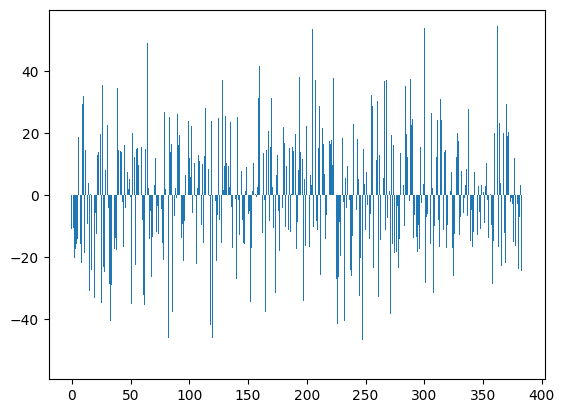

In [21]:
import matplotlib.pyplot as plt
plt.bar(range(len(scaled_vector)), scaled_vector.flatten())
plt.show()


In [22]:
query_embeddings = embedding_function(generated_queries)
adapted_query_embeddings = np.matmul(best_matrix, np.array(query_embeddings).T).T

projected_query_embeddings = project_embeddings(query_embeddings, umap_transform)
projected_adapted_query_embeddings = project_embeddings(adapted_query_embeddings, umap_transform)

  0%|          | 0/15 [00:00<?, ?it/s]/Users/mdp/Desktop/furkan/nlp/nlp-tutorials/43_Advanced_Retrieval_for_AI_with_Chroma/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mdp/Desktop/furkan/nlp/nlp-tutorials/43_Advanced_Retrieval_for_AI_with_Chroma/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mdp/Desktop/furkan/nlp/nlp-tutorials/43_Advanced_Retrieval_for_AI_with_Chroma/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mdp/Desktop/furkan/nlp/nlp-tutorials/43_Advanced_Retrieval_for_AI_with_Chroma/.venv/lib/python3.13/site-packages/sklearn/utils/dep

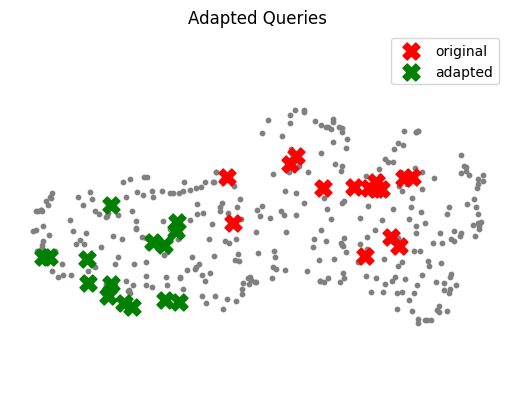

In [23]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embeddings[:, 0], projected_query_embeddings[:, 1], s=150, marker='X', color='r', label="original")
plt.scatter(projected_adapted_query_embeddings[:, 0], projected_adapted_query_embeddings[:, 1], s=150, marker='X', color='green', label="adapted")

plt.gca().set_aspect('equal', 'datalim')
plt.title("Adapted Queries")
plt.axis('off')
plt.legend()